# deep profile 'sanity' check

This script will read in the synthetic profile

1) read the adjusted o2 data using either one of three calibration methods including (a) gain correction using climatological surface saturation (Takeshita et al 2013), (b) gain correction using surface in-air calibration (Johnson et al 2015), or other types. 

2) interpolate the data onto standard depth levels (WOA2009 standard z level)

3) compare it against the WOA09 data in the deep ocean below 1,000m (match up with the nearest climatology grid) 

4) calculate RMSE for each float sensor, and flag apparently problematic ones

5) save interpolated profile data as netCDF file

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from scipy import interpolate as itp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
#np.seterr(divide='ignore')

In [2]:
# set up standard depth, year, month
zstd=np.array([0,10,20,30,50,75,100,125,150,200,250,300,400,
               500,600,700,800,900,1000,1100,1200,1300,1400,
               1500,1750,2000])
year=np.arange(2011,2020,1)
month=np.arange(1,13,1)

In [3]:
# generate index for downloaded synthetic profiles
os.system('ls data/*.nc > available_floats.txt')
fn=pd.read_csv('available_floats.txt',header=None,names=['file'])
df=pd.read_csv('float_calibration_statistics_ver.Feb1.csv')
calib_ind=df['Calib indicator']
df

,Unnamed: 0,WMO ID,Calib indicator,Calib group type,Calibration comment,QC flag
0,0,1900650,3,Type 3: Other,No significant oxygen drift detected - Calibra...,NaN
1,1,1900651,3,Type 3: Other,No significant oxygen drift detected - Calibra...,NaN
2,2,1900652,3,Type 3: Other,No significant oxygen drift detected - Calibra...,NaN
3,3,1900722,3,Type 3: Other,DOXY_ADJUSTED computed using Stern-Volmer equa...,NaN
4,4,1900943,1,"Type 1: Gain Corr, surf sat clim","Adjusted with WOA climatology, optode simple c...",NaN
...,...,...,...,...,...,...
1523,1523,7900863,4,Type 4: Unknown/bad data,unknown,NaN
1524,1524,7900881,4,Type 4: Unknown/bad data,unknown,NaN
1525,1525,7900907,4,Type 4: Unknown/bad data,unknown,NaN
1526,1526,7900915,4,Type 4: Unknown/bad data,unknown,NaN


In [4]:
# open WOA data files
dmon=xr.open_dataset('WOA09/dissolved_oxygen_monthly_1deg.nc',decode_times=False)
dann=xr.open_dataset('WOA09/dissolved_oxygen_annual_1deg.nc',decode_times=False)

In [5]:
# open the profile data file, count the number of profiles and depth levels
N=np.size(fn)
Nprf=np.empty((N,))
Nlev=np.empty((N,))
o2rmse=np.empty((N,))
o2rmse500=np.empty((N,))
o2rmse1000=np.empty((N,))
o2rmse_adjusted=np.empty((N,))
o2rmse500_adjusted=np.empty((N,))
o2rmse1000_adjusted=np.empty((N,))
file_output=np.empty((N,),np.dtype('U100'))

! mkdir -p compare_woa_v3

# First, match up profiles for type 1 calibration
#
for n in range(N):
    #
    if (np.remainder(n,50)==0):
        print('completed '+str(n)+' floats')
    #
    if (calib_ind[n]<=3):
    #
        ds=xr.open_dataset(fn['file'][n])
        Ntmp=np.shape(ds['PRES'])
        Nprf[n]=Ntmp[0]
        Nlev[n]=Ntmp[1]
        pid=ds['PLATFORM_NUMBER'][0].astype(str)
        o2=ds['DOXY'].astype(float)
        o2a=ds['DOXY_ADJUSTED'].astype(float)
        z=ds['PRES'].astype(float)
        x=ds['LONGITUDE'].astype(float)
        y=ds['LATITUDE'].astype(float)
        date=ds['JULD']
        # get QC flags
        date_qc=ds['JULD_QC'].astype(int)
        pos_qc=ds['POSITION_QC'].astype(int)
        o2_qc=ds['PROFILE_DOXY_QC'].astype(str)
        o2qcflg=ds['DOXY_QC'].astype(str)
        o2aqcflg=ds['DOXY_ADJUSTED_QC'].astype(str)
        #
        pdate=pd.to_datetime(date)
        year=pdate.year
        mon=pdate.month
        goodprf=(pos_qc==1) & (date_qc==1)    
        # prepare o2woa data array for this particular float
        o2woa=xr.DataArray( np.empty((int(Nprf[n]),26)) ,  
                       [("profile",range(0,int(Nprf[n]))) , 
                        ("depth",zstd) 
                       ],name='O2_WOA')
        o2flt=xr.DataArray( np.empty((int(Nprf[n]),26)) ,  
                       [("profile",range(0,int(Nprf[n]))) , 
                        ("depth",zstd) 
                       ],name='O2_FLT')
        o2flt_adjusted=xr.DataArray( np.empty((int(Nprf[n]),26)) ,  
                       [("profile",range(0,int(Nprf[n]))) , 
                        ("depth",zstd) 
                       ],name='O2_FLT_ADJUSTED')
        # fill in the WOA09 data
        for m in range(0,int(Nprf[n])):
            if ((goodprf[m]==True) & ((x[m]+y[m])<450)):
                # co-locate WOA profile
                if (x[m]<0):
                    x360=x[m]+360.0
                else:
                    x360=x[m]    
                o2woa_ann=dann.o_an.sel(lon=x360,lat=y[m],method='nearest')*43.570
                tmp=dmon.o_an.sel(lon=x360,lat=y[m],method='nearest')*43.570
                o2woa_mon=tmp[int(mon[m]-1),:]
                o2woa[m,:26]=o2woa_ann.data[0,0:26]
                o2woa[m,:24]=o2woa_mon.data
                # get the profile data
                oflg=o2qcflg[m,:]
                ogood=((oflg=='1')|(oflg=='2')|(oflg=='5')|(oflg=='8'))
                o20=o2[m,ogood]
                z0=z[m,ogood]            
                # linearly interpolate
                if (np.size(o20)>1):
                    fo2=itp.interp1d(z0,o20,'linear',bounds_error=False,fill_value=np.nan)
                    o2flt[m,:]=fo2(zstd)
                else:
                    o2flt[m,:]=np.nan
                # get the adjusted profile data
                oflg=o2aqcflg[m,:]
                ogood=((oflg=='1')|(oflg=='2')|(oflg=='5')|(oflg=='8'))
                o20=o2a[m,ogood]
                z0=z[m,ogood]
                # linearly interpolate
                if (np.size(o20)>1):
                    fo2=itp.interp1d(z0,o20,'linear',bounds_error=False,fill_value=np.nan)
                    o2flt_adjusted[m,:]=fo2(zstd)
                else:
                    o2flt_adjusted[m,:]=np.nan
            else: 
                # put nan if profiles cannot be co-located
                o2woa[m,:]=np.nan
                o2flt[m,:]=np.nan
                o2flt_adjusted[m,:]=np.nan
        # end for loop for profiles from a single float
        # now take the difference
        o2dif=o2flt-o2woa
        o2dif_adjusted=o2flt_adjusted-o2woa
        # calculate RMSE
        o2rmse[n]=np.sqrt((o2dif**2).mean(dim='profile').mean(dim='depth'))
        o2rmse500[n]=np.sqrt((o2dif[:,14:]**2).mean(dim='profile').mean(dim='depth'))
        o2rmse1000[n]=np.sqrt((o2dif[:,19:]**2).mean(dim='profile').mean(dim='depth'))
        #
        o2rmse_adjusted[n]=np.sqrt((o2dif_adjusted**2).mean(dim='profile').mean(dim='depth'))
        o2rmse500_adjusted[n]=np.sqrt((o2dif_adjusted[:,14:]**2).mean(dim='profile').mean(dim='depth'))
        o2rmse1000_adjusted[n]=np.sqrt((o2dif_adjusted[:,19:]**2).mean(dim='profile').mean(dim='depth'))
        # optional: merge data arrays into a new dataset and save it in netcdf format 
        if (sum(goodprf)>=1):
            ds_out=xr.merge([o2woa,o2flt,o2flt_adjusted,x,y,date])
            wn='compare_woa_v3/'+str(np.char.strip(pid.data))+'_26lev.nc'
            ds_out.to_netcdf(wn,mode='w')
            file_output[n]=wn
    # for bad data, just fill nan
    else: 
        o2rmse[n]=np.nan
        o2rmse500[n]=np.nan
        o2rmse1000[n]=np.nan
        o2rmse_adjusted[n]=np.nan
        o2rmse500_adjusted[n]=np.nan
        o2rmse1000_adjusted[n]=np.nan

completed 0 floats
completed 50 floats
completed 100 floats
completed 150 floats
completed 200 floats
completed 250 floats
completed 300 floats
completed 350 floats
completed 400 floats
completed 450 floats
completed 500 floats
completed 550 floats
completed 600 floats
completed 650 floats
completed 700 floats
completed 750 floats
completed 800 floats
completed 850 floats
completed 900 floats
completed 950 floats
completed 1000 floats
completed 1050 floats
completed 1100 floats
completed 1150 floats
completed 1200 floats
completed 1250 floats
completed 1300 floats
completed 1350 floats
completed 1400 floats
completed 1450 floats
completed 1500 floats


In [6]:
wmoid=df['WMO ID']
calib_ind=df['Calib indicator']
a=np.array([wmoid, calib_ind, Nprf, o2rmse, o2rmse500, o2rmse1000, o2rmse_adjusted, 
            o2rmse500_adjusted, o2rmse1000_adjusted, file_output])
float_stats=pd.DataFrame(data=a.T,
                        columns=['WMO ID','Calib Type','Num Prof','RMSE(0-2000m)','RMSE(500-2000m)','RMSE(1000-2000m)'
                                 ,'RMSE_ADJ(0-2000m)','RMSE_ADJ(500-2000m)','RMSE_ADJ(1000-2000m)','File'])
float_stats.to_csv('float_summary_statsitics_ver.Feb1.csv')

based below 1000m RMSE data
there are  562  floats with clim surf sat calibration
there are  265  floats with acceptable deep ocean RMSE (rmse < 10uM)


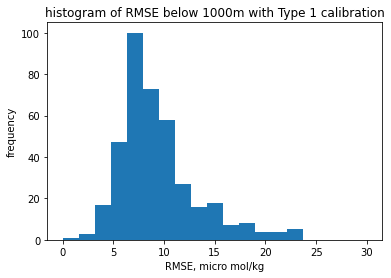

In [14]:
# Calib type 1 statistics
ind=np.where((calib_ind==1))
#
rmse=o2rmse1000_adjusted[ind]
#
isgood=np.where(rmse<10)
#
bins=np.linspace(0,30,20)
hdat=plt.hist(rmse,bins)
plt.title('histogram of RMSE below 1000m with Type 1 calibration')
plt.xlabel('RMSE, micro mol/kg')
plt.ylabel('frequency')
#fn=df['File'].to_numpy()
print('based below 1000m RMSE data')
print('there are ',np.size(ind),' floats with clim surf sat calibration')
print('there are ',np.size(isgood),' floats with acceptable deep ocean RMSE (rmse < 10uM)')
plt.savefig('O2CalibType1_RMSE_histogram.pdf',bbox_inches="tight",dpi=300)
plt.show()
# generate a subset
wmoid1=wmoid[ind[0][isgood[0]]]
fltnum1=ind[0][isgood[0]]
o2rmse_adjusted1=o2rmse_adjusted[ind[0][isgood[0]]] 
o2rmse500_adjusted1=o2rmse500_adjusted[ind[0][isgood[0]]] 
o2rmse1000_adjusted1=o2rmse1000_adjusted[ind[0][isgood[0]]] 
file_output1=file_output[ind[0][isgood[0]]]
a=np.array([wmoid1, o2rmse_adjusted1, 
            o2rmse500_adjusted1, o2rmse1000_adjusted1, file_output1])
float_stats=pd.DataFrame(data=a.T,
                        columns=['WMO ID',
                                 'RMSE_ADJ(0-2000m)','RMSE_ADJ(500-2000m)','RMSE_ADJ(1000-2000m)','File'])
float_stats.to_csv('float_Type1_summary_ver.Feb1.csv')

based below 1000m RMSE data
there are  359  floats with in-air calibration
there are  203  floats with acceptable deep ocean RMSE (rmse < 10uM)


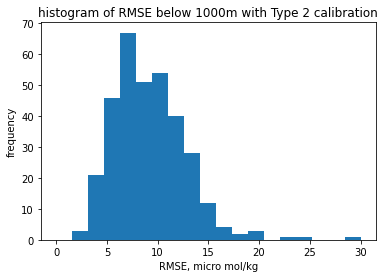

In [15]:
# Calib type 2 statistics
ind=np.where((calib_ind==2))
#
rmse=o2rmse1000_adjusted[ind]
#
isgood=np.where(rmse<10)
#
bins=np.linspace(0,30,20)
hdat=plt.hist(rmse,bins)
plt.title('histogram of RMSE below 1000m with Type 2 calibration')
plt.xlabel('RMSE, micro mol/kg')
plt.ylabel('frequency')
#fn=df['File'].to_numpy()
print('based below 1000m RMSE data')
print('there are ',np.size(ind),' floats with in-air calibration')
print('there are ',np.size(isgood),' floats with acceptable deep ocean RMSE (rmse < 10uM)')
plt.savefig('O2CalibType2_RMSE_histogram.pdf',bbox_inches="tight",dpi=300)
plt.show()
# generate a subset
wmoid2=wmoid[ind[0][isgood[0]]]
fltnum2=ind[0][isgood[0]]
o2rmse_adjusted2=o2rmse_adjusted[ind[0][isgood[0]]] 
o2rmse500_adjusted2=o2rmse500_adjusted[ind[0][isgood[0]]] 
o2rmse1000_adjusted2=o2rmse1000_adjusted[ind[0][isgood[0]]] 
file_output2=file_output[ind[0][isgood[0]]]
a=np.array([wmoid2, o2rmse_adjusted2, 
            o2rmse500_adjusted2, o2rmse1000_adjusted2, file_output2])
float_stats=pd.DataFrame(data=a.T,
                        columns=['WMO ID',
                                 'RMSE_ADJ(0-2000m)','RMSE_ADJ(500-2000m)','RMSE_ADJ(1000-2000m)','File'])
float_stats.to_csv('float_Type2_summary_ver.Feb1.csv')

based below 1000m RMSE data
there are  172  floats with other calibration
there are  104  floats with acceptable deep ocean RMSE (rmse < 10uM)


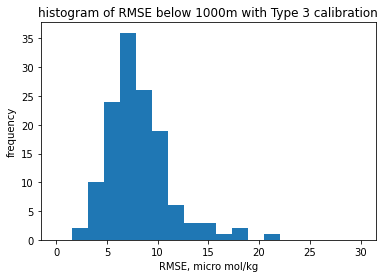

In [16]:
# Calib type 3 statistics
ind=np.where((calib_ind==3))
#
rmse=o2rmse1000_adjusted[ind]
#
isgood=np.where(rmse<10)
#
bins=np.linspace(0,30,20)
hdat=plt.hist(rmse,bins)
plt.title('histogram of RMSE below 1000m with Type 3 calibration')
plt.xlabel('RMSE, micro mol/kg')
plt.ylabel('frequency')
#fn=df['File'].to_numpy()
print('based below 1000m RMSE data')
print('there are ',np.size(ind),' floats with other calibration')
print('there are ',np.size(isgood),' floats with acceptable deep ocean RMSE (rmse < 10uM)')
plt.savefig('O2CalibType3_RMSE_histogram.pdf',bbox_inches="tight",dpi=300)
plt.show()
# generate a subset
wmoid3=wmoid[ind[0][isgood[0]]]
fltnum3=ind[0][isgood[0]]
o2rmse_adjusted3=o2rmse_adjusted[ind[0][isgood[0]]] 
o2rmse500_adjusted3=o2rmse500_adjusted[ind[0][isgood[0]]] 
o2rmse1000_adjusted3=o2rmse1000_adjusted[ind[0][isgood[0]]] 
file_output3=file_output[ind[0][isgood[0]]]
a=np.array([wmoid3, o2rmse_adjusted3, 
            o2rmse500_adjusted3, o2rmse1000_adjusted3, file_output3])
float_stats=pd.DataFrame(data=a.T,
                        columns=['WMO ID',
                                 'RMSE_ADJ(0-2000m)','RMSE_ADJ(500-2000m)','RMSE_ADJ(1000-2000m)','File'])
float_stats.to_csv('float_Type3_summary_ver.Feb1.csv')

/Users/takamitsu3/opt/anaconda3/envs/calc/lib/python3.8/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/takamitsu3/opt/anaconda3/envs/calc/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/Users/takamitsu3/opt/anaconda3/envs/calc/lib/python3.8/site-packages/cartopy/crs.py:836: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = list(multi_lin

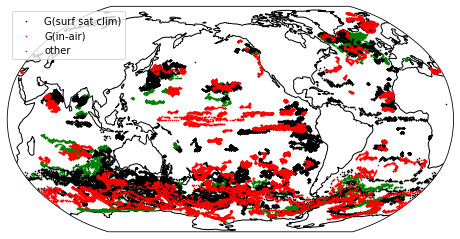

In [10]:
# map the distribution of profiles
fig=plt.figure(figsize=(8,5))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-150))
ax.coastlines()
# type 1 black dots
n1=fltnum1
for n in range(0,np.size(n1)): 
    ds=xr.open_dataset(fn['file'][int(n1[n])])
    x=ds['LONGITUDE']
    y=ds['LATITUDE']
    p1=ax.scatter(x,y,s=1.5,color='k',marker='.',transform=ccrs.PlateCarree(),zorder=98,rasterized=True)
# type 2 red dots
n1=fltnum2
for n in range(0,np.size(n1)): 
    ds=xr.open_dataset(fn['file'][int(n1[n])])
    x=ds['LONGITUDE']
    y=ds['LATITUDE']
    p2=ax.scatter(x,y,s=1.5,color='r',marker='.',transform=ccrs.PlateCarree(),zorder=99,rasterized=True)
# type 3 green dots
n1=fltnum3
for n in range(0,np.size(n1)): 
    ds=xr.open_dataset(fn['file'][int(n1[n])])
    x=ds['LONGITUDE']
    y=ds['LATITUDE']
    p3=ax.scatter(x,y,s=1.5,color='g',marker='.',transform=ccrs.PlateCarree(),zorder=10,rasterized=True)
#
plt.legend([p1,p2,p3],['G(surf sat clim)','G(in-air)','other'])
plt.savefig('O2CalibType_maps.pdf',bbox_inches="tight",dpi=300)